In [1]:
import os
import json
import numpy as np
from quinine import QuinineArgumentParser
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F

import sys
sys.path.append('/home/jupyter/project/looped_transformer/scripts')
from nano_gpt import GPT2Model, GPT2Config

from utils import aggregate_metrics, eval_unlooped_model, eval_looped_model, get_model

In [2]:
fig_hparam = {
    'figsize': (8, 5),
    'labelsize': 28,
    'ticksize': 20,
    'linewidth': 5,
    'fontsize': 15,
    'titlesize': 20,
    'markersize': 15
}

# font specification
fontdict = {'family': 'serif',
         'size': fig_hparam['fontsize'],
         }

In [3]:
device = torch.device('cuda:0')

In [4]:
class SparseLinearRegression():
    def __init__(self, batch_size, n_points, n_dims, n_dims_truncated, device, w_star=None, sparsity=3):
        super(SparseLinearRegression, self).__init__()
        self.device = device
        self.xs = torch.randn(batch_size, n_points, n_dims).to(device)
        self.xs[..., n_dims_truncated:] = 0
        w_b = torch.randn(batch_size, n_dims, 1) if w_star is None else w_star.to(device)  # [B, d, 1]
        w_b[:, n_dims_truncated:] = 0
        self.w_b = w_b.to(device)
        
        self.sparsity = sparsity
        valid_coords = n_dims
        for i, w in enumerate(self.w_b):  # [B, d, 1]
            mask = torch.ones(n_dims).bool()  # [d]
            perm = torch.randperm(valid_coords)
            mask[perm[:sparsity]] = False
            w[mask] = 0  # w shape [d, 1]

        self.ys = (self.xs @ self.w_b).sum(-1)  # [B, n]
        
        
        
sample_size = 1280
batch_size = 128
n_points = 41
n_dims_truncated = 20
n_dims = 20

real_task = SparseLinearRegression(sample_size, n_points, n_dims, n_dims_truncated, device)
xs, ys, w_b = real_task.xs, real_task.ys, real_task.w_b

In [5]:
result_dir = '/home/jupyter/project/looped_transformer/results2/sparse_LR_baseline'
run_id = '0525204918-SparseLR_baseline-7984'

from models import TransformerModel

n_positions = 101
n_embd = 256
n_layer = 12
n_head = 8

model = TransformerModel(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)

err, y_pred_total = eval_unlooped_model(model, xs, ys)


number of parameters: 9.48M


/home/jupyter/project/looped_transformer/jupyter_notebooks/utils.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu'

In [6]:
result_errs = {}
result_errs['Transformer'] = err

## Load looped transformer b=12, T=5

In [9]:
from models import TransformerModelLooped

result_dir = '../results2/sparse_LR_loop'
run_id = '0526032309-SparseLR_loop_L1_ends{12}_T{5}-6884'

n_positions = 101
n_embd = 256
n_head = 8
T = 500
n_layer = 1

model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)

err, loop_err = eval_looped_model(model, xs, ys, loop_max=T)

result_errs['Looped Transformer b12t5'] = err

number of parameters: 0.79M
0


## Load looped transformer b=30, T=5

In [12]:
from models import TransformerModelLooped

result_dir = '../results2/sparse_LR_loop'
run_id = '0526074643-SparseLR_loop_L1_ends{30}_T{5}-f160'

n_positions = 101
n_embd = 256
n_head = 8
T = 500
n_layer = 1

model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)

err, loop_err = eval_looped_model(model, xs, ys, loop_max=T)

result_errs['Looped Transformer b30t5'] = err


number of parameters: 0.79M
0


### Also get the "weak" baseline

In [13]:
from utils import get_relevant_baselines
from utils import LeastSquaresModel, NNModel, AveragingModel, LassoModel

baselines = get_relevant_baselines("sparse_linear_regression")
baselines = [
    (LeastSquaresModel, {}),
    (NNModel, {"n_neighbors": 3}),
    (AveragingModel, {}),
] + [
#     (LassoModel, {"alpha": alpha}) for alpha in [1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
    (LassoModel, {"alpha": alpha}) for alpha in [0.01]
]
baseline_models = [model_cls(**kwargs) for model_cls, kwargs in baselines]
baseline_errs = {}
for baseline_model in baseline_models:
    y_pred = baseline_model(xs, ys)
    err = (y_pred.cpu() - ys.cpu()).square()
    result_errs[baseline_model.name] = err

In [14]:
result_errs_agg = aggregate_metrics(result_errs, 3)

In [15]:
result_errs_agg

{'Transformer': {'mean': tensor([0.9537, 0.9252, 0.8799, 0.7900, 0.6589, 0.4731, 0.3838, 0.3311, 0.2061,
          0.1462, 0.1208, 0.0708, 0.0450, 0.0340, 0.0242, 0.0169, 0.0129, 0.0099,
          0.0087, 0.0076, 0.0055, 0.0045, 0.0040, 0.0040, 0.0030, 0.0034, 0.0025,
          0.0023, 0.0025, 0.0021, 0.0019, 0.0018, 0.0016, 0.0016, 0.0015, 0.0014,
          0.0014, 0.0014, 0.0014, 0.0014, 0.0014]),
  'std': tensor([1.7625, 1.8590, 1.8904, 1.4978, 1.6920, 0.9733, 1.0105, 0.9957, 0.6279,
          0.4929, 0.7834, 0.2342, 0.1650, 0.1158, 0.0963, 0.0560, 0.0433, 0.0284,
          0.0283, 0.0266, 0.0128, 0.0129, 0.0116, 0.0222, 0.0060, 0.0087, 0.0096,
          0.0053, 0.0063, 0.0045, 0.0035, 0.0036, 0.0032, 0.0051, 0.0028, 0.0031,
          0.0026, 0.0033, 0.0028, 0.0032, 0.0033]),
  'bootstrap_low': tensor([0.8749, 0.8475, 0.7963, 0.7211, 0.5823, 0.4299, 0.3398, 0.2876, 0.1792,
          0.1254, 0.0886, 0.0609, 0.0382, 0.0290, 0.0201, 0.0145, 0.0110, 0.0087,
          0.0074, 0.0065, 0.0

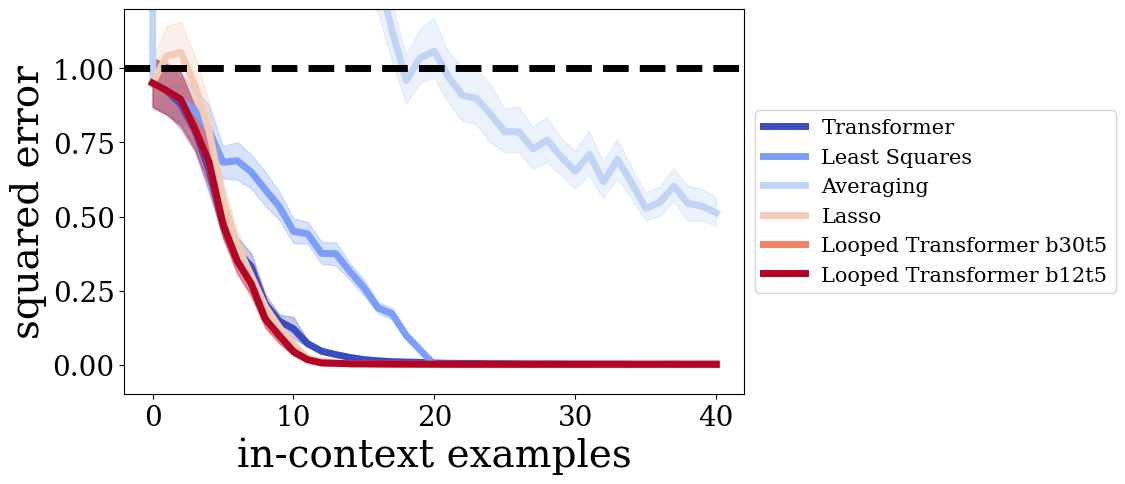

In [20]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])

err_result_dict_agg = result_errs_agg

cmap = matplotlib.cm.get_cmap("coolwarm")
result_name_list = ['Transformer', 'Least Squares', 'Averaging', 'Lasso (alpha=0.01)', 'Looped Transformer b30t5', 'Looped Transformer b12t5']  # 
colors = cmap(np.linspace(0, 1, len(result_name_list)))
for idx, model_name in enumerate(result_name_list):
    err = err_result_dict_agg[model_name]["mean"]
    if "Lasso" in model_name:
        label_name = "Lasso"
    else:
        label_name = model_name
    ax.plot(err, color=colors[idx], lw=fig_hparam['linewidth'], label=label_name)
    low = err_result_dict_agg[model_name]["bootstrap_low"]
    high = err_result_dict_agg[model_name]["bootstrap_high"]
    ax.fill_between(range(len(low)), low, high, alpha=0.3, color=colors[idx])

ax.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
ax.axhline(1, color='k', ls='--', lw=fig_hparam['linewidth'])
ax.set_ylim(-0.1, 1.2)
# plt.xticks(np.arange(0, n_points))
plt.rc('font', family='serif')
ax.set_xlabel("in-context examples", fontsize=fig_hparam['labelsize'])
y_label = ax.set_ylabel("squared error", fontsize=fig_hparam['labelsize'])
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fig_hparam['fontsize'])


plt.savefig("/home/jupyter/project/looped_transformer/results2/Figures/SparseLR_err.pdf", format='pdf', dpi=600, bbox_inches='tight')